In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## 1. 데이터 전처리

### 데이터 로딩

In [6]:
# 로컬 csv 파일 로드
file = "C:/Users/송이두/Desktop/가천대/2-1/인공지능개론/과제/data/titanic.csv"
titanic_data = pd.read_csv(file)

In [7]:
# 데이터셋의 첫 5행 출력
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# 데이터셋의 전반적인 정보 확인
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 결측치 확인

In [61]:
#isna()를 통해 각 데이터의 결측치 여부(True or False) 확인, sum()을 통해 True 값 합계 확인.
titanic_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### 결측치 제거

In [11]:
# 수치형 특성인 Age는 평균값으로 대체
mean_value = titanic_data['Age'].mean()
titanic_data.fillna({'Age': mean_value}, inplace=True)
# 범주형 특성인 Cabin과 Embarked는 최빈값으로 대체
column_to_fillna = ['Cabin', 'Embarked']
for column in column_to_fillna:
    freq_value = titanic_data[column].mode()
    titanic_data.fillna({column: freq_value}, inplace=True)

In [12]:
# 결측치 제거 후 데이터셋 확인
titanic_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### 레이블 확인 (imbalanced data)<br/>
레이블 확인을 통해 사망자가 생존자보다 많음을 알 수 있다.<br/>
심각한 수준의 데이터 불균형은 아니지만, 모델 성능에 영향을 미칠 수 있는 잠재적인 불균형이다.

In [19]:
# value_counts()를 이용해 타깃 레이블의 빈도수 확인
titanic_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

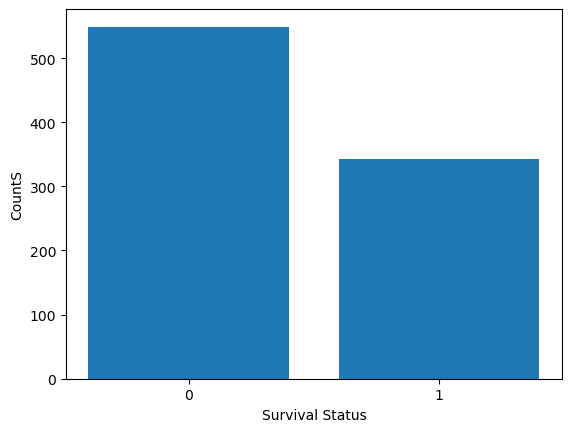

In [26]:
# plt 차트를 이용해 시각화
x = titanic_data['Survived'].value_counts().index
y = titanic_data['Survived'].value_counts().values
plt.bar(x, y)
plt.xticks(x)
plt.xlabel('Survival Status')
plt.ylabel("CountS")
plt.show()

### 불필요한 컬럼 제거<br/>
타이타닉호 사망자, 생존자 분류에 불필요한 컬럼으로는 'PassengerId', 'Name', 'Ticket', 'Embarked'가 있다.

In [29]:
# drop()을 통해 불필요한 컬럼 제거
dropped_data = titanic_data.drop(['PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1)

In [30]:
# 데이터셋 확인
dropped_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,0,3,male,22.0,1,0,7.2500,B96 B98
1,1,1,female,38.0,1,0,71.2833,C85
2,1,3,female,26.0,0,0,7.9250,B96 B98
3,1,1,female,35.0,1,0,53.1000,C123
4,0,3,male,35.0,0,0,8.0500,B96 B98


### 인코딩<br/>
데이터 학습을 위해 문자형 특성을 숫자형으로 변환한다.<br/>
문자형 특성에는 'Sex', 'Cabin'이 있다.

In [33]:
# Sex 컬럼의 고유값 확인
dropped_data['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [34]:
# Cabin 컬럼의 고유값 확인
dropped_data['Cabin'].value_counts()

Cabin
B96 B98        691
G6               4
C23 C25 C27      4
C22 C26          3
F33              3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 147, dtype: int64

In [36]:
#인코더 선언
label_encoder = LabelEncoder()
#인코딩 필요한 컬럼명 리스트 생성
column_to_encode = ['Sex', 'Cabin']
#인코딩 적용
encoded_data = dropped_data.copy()
for column in column_to_encode:
    encoded_data[column] = label_encoder.fit_transform(encoded_data[column])

In [39]:
# Sex 컬럼의 고유값 확인
encoded_data['Sex'].value_counts()

Sex
1    577
0    314
Name: count, dtype: int64

In [40]:
# Cabin 컬럼의 고유값 확인
encoded_data['Cabin'].value_counts()

Cabin
47     691
145      4
63       4
62       3
142      3
      ... 
124      1
76       1
72       1
125      1
60       1
Name: count, Length: 147, dtype: int64

## 2. 데이터 훈련 및 예측

### 훈련 세트, 테스트 세트 분리

In [41]:
X = encoded_data.drop(['Survived'], axis=1)
y = encoded_data['Survived'].copy()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### DT(의사결정 트리) 분류

In [48]:
# 모델 선언
dt_clf = DecisionTreeClassifier(random_state=0)
# 모델 학습
dt_clf.fit(X_train, y_train)
#예측 생성
pred_dt = dt_clf.predict(X_test)
# accuracy 및 confusion matrix 확인
acc_dt = accuracy_score(y_test, pred_dt)
print(f"accuracy: {acc_dt}")
cm_dt = confusion_matrix(y_test, pred_dt)
print(f"confusion matrix:\n{cm_dt}")

accuracy: 0.7877094972067039
confusion matrix:
[[96 14]
 [24 45]]


### RF(랜덤 포레스트) 분류

In [51]:
# 모델 선언
rf_clf = RandomForestClassifier(random_state=0)
# 모델 학습
rf_clf.fit(X_train, y_train)
#예측 생성
pred_rf = rf_clf.predict(X_test)
# accuracy 및 confusion matrix 확인
acc_rf = accuracy_score(y_test, pred_rf)
print(f"accuracy: {acc_rf}")
cm_rf = confusion_matrix(y_test, pred_rf)
print(f"confusion matrix:\n{cm_rf}")

accuracy: 0.8100558659217877
confusion matrix:
[[96 14]
 [24 45]]


### LR(로지스틱 회귀) 분류

In [63]:
# 모델 선언
lr_clf = LogisticRegression(random_state=0)
# 모델의 수렴을 위한 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 모델 학습
lr_clf.fit(X_train_scaled, y_train)
#예측 생성
pred_lr = lr_clf.predict(X_test_scaled)
# accuracy 및 confusion matrix 확인
acc_lr = accuracy_score(y_test, pred_lr)
print(f"accuracy: {acc_lr}")
cm_lr = confusion_matrix(y_test, pred_lr)
print(f"confusion matrix:\n{cm_lr}")

accuracy: 0.8212290502793296
confusion matrix:
[[95 15]
 [17 52]]


### KNN(K 최근접 이웃) 분류

In [57]:
#모델 선언
knn_clf = KNeighborsClassifier(n_neighbors=3)
# 모델 학습
knn_clf.fit(X_train, y_train)
#예측 생성
pred_knn = knn_clf.predict(X_test)
# accuracy 및 confusion matrix 확인
acc_knn = accuracy_score(y_test, pred_knn)
print(f"accuracy: {acc_knn}")
cm_knn = confusion_matrix(y_test, pred_knn)
print(f"confusion matrix:\n{cm_knn}")

accuracy: 0.7262569832402235
confusion matrix:
[[92 18]
 [31 38]]


### SVM(서포트 벡터 머신) 분류

In [60]:
# 모델 선언
svm_clf = SVC(random_state=0)
# 모델 학습
svm_clf.fit(X_train, y_train)
#예측 생성
pred_svm = svm_clf.predict(X_test)
# accuracy 및 confusion matrix 확인
acc_svm = accuracy_score(y_test, pred_svm)
print(f"accuracy: {acc_svm}")
cm_svm = confusion_matrix(y_test, pred_svm)
print(f"confusion matrix:\n{cm_svm}")

accuracy: 0.7094972067039106
confusion matrix:
[[101   9]
 [ 43  26]]
